In [1]:
%autosave 10

import pandas as pd
import math

from HW5Utils import *
from KParameters import *
from RParameters import *

Autosaving every 10 seconds


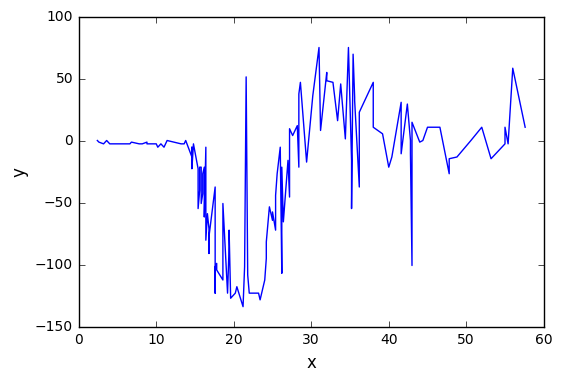

In [2]:
data = getData('non-parametric.csv')
showData(data)

In [3]:
kernels = [
    (lambda x: gaussianKernel(x), 'Gaussian'),
    (lambda x: epanechnikovKernel(x), 'Epanechnikov')
]

In [4]:
def kernelRegressionCalculation(testPoint, trainSet, params):
    numerator = 0
    denominator = 0
    h = params.h
    if h is None:
        distances = []
        for trainPoint in trainSet.as_matrix([['x', 'y']]):
            distances.append(abs(testPoint[0] - trainPoint[0]))
        distances = sorted(distances)
        h = distances[params.k - 1]
    for trainPoint in trainSet.as_matrix([['x', 'y']]):
        numerator += trainPoint[1] * params.kernel[0](abs(testPoint[0] - trainPoint[0]) / h)
        denominator += params.kernel[0](abs(testPoint[0] - trainPoint[0]) / h)
    return float('inf') if denominator == 0 else numerator / denominator

def kernelRegression(data):
    H_MIN = 10 ** (-9)
    H_MAX = 10 ** 9
    H_STEP = 10
    
    K_MIN = 5
    K_MAX = 20
    K_STEP = 1
    
    params = KParameters(mse=float('inf'))
    for kernel in kernels:
        h = H_MIN
        while h <= H_MAX:
            mse = 0.0
            for i in range(len(data)):
                testPoint = list(data.loc[i])[1:]
                trainSet = pd.concat([data[:i], data[(i + 1):]])
                predictedValue = kernelRegressionCalculation(testPoint, trainSet, KParameters(kernel=kernel, h=h))
                mse += math.pow(predictedValue - testPoint[1], 2)
            mse /= len(data)
            if mse < params.mse:
                params = KParameters(kernel=kernel, h=h, mse=mse)
            h *= H_STEP
        k = K_MIN
        while k <= K_MAX:
            mse = 0.0
            for i in range(len(data)):
                testPoint = list(data.loc[i])[1:]
                trainSet = pd.concat([data[:i], data[(i + 1):]])
                predictedValue = kernelRegressionCalculation(testPoint, trainSet, KParameters(kernel=kernel, k=k))
                mse += math.pow(predictedValue - testPoint[1], 2)
            mse /= len(data)
            if mse < params.mse:
                params = KParameters(kernel=kernel, k=k, mse=mse)
            k += K_STEP
    return params

In [5]:
bestKParameters = kernelRegression(data)
print(bestKParameters)

{kernel=Gaussian, h=None, k=7, mse=932.1389340738111}


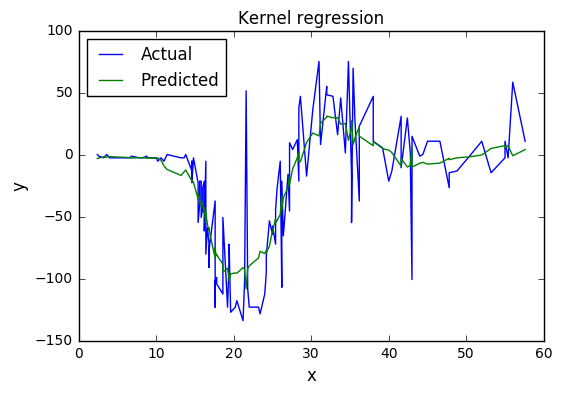

In [6]:
predictedKData = pd.DataFrame(columns=['x', 'y'])
for i in range(len(data)):
    testPoint = list(data.loc[i])[1:]
    trainSet = pd.concat([data[:i], data[(i + 1):]])
    predictedValue = kernelRegressionCalculation(testPoint, trainSet, bestKParameters)
    resultPoint = pd.DataFrame([[testPoint[0], predictedValue]], columns=['x', 'y'])
    predictedKData = predictedKData.append(resultPoint, ignore_index=True)

showPredictedData(data, predictedKData, 'Kernel regression')

In [7]:
def quarticFunc(x):
    return 15.0 / 16 * (1 - x ** 2) ** 2 * (1 if abs(x) <= 1 else 0)

def lowess(data, params):
    EPS = 10 ** (-5)
    length = len(data)
    ds = [1.0] * length
    prevDs = []
    
    for iter in range(3):
        prevDs = list(ds)
        err = [0] * length
        for i in range(length):
            point = data[i]
            distances = []
            for j in range(length):
                if j != i:
                    distances.append(abs(point[0] - data[j][0]))
            distances = sorted(distances)
            h = distances[params.k + 1]
            numerator = 0
            denominator = 0
            for j in range(length):
                if j != i:
                    newPoint = data[j]
                    numerator += newPoint[1] * ds[j] * params.kernel[0](abs(newPoint[0] - point[0]) / h)
                    denominator += ds[j] * params.kernel[0](abs(newPoint[0] - point[0]) / h)
            err[i] = abs(point[1] - (numerator / denominator))
        sortedErr = sorted(list(err))
        median = 0
        if length % 2 == 0:
            median = (sortedErr[(length - 1) // 2] + sortedErr[(length - 1) // 2 + 1]) / 2.0
        else:
            median = sortedErr[(length - 1) // 2]
        for i in range(length):
            ds[i] = quarticFunc(abs(err[i]) / (6 * median))
    return ds

def robustRegressionCalculation(testPoint, trainSet, params):
    numerator = 0
    denominator = 0
    distances = []
    for trainPoint in trainSet.as_matrix([['x', 'y']]):
        distances.append(abs(testPoint[0] - trainPoint[0]))
    distances = sorted(distances)
    h = distances[params.k - 1]
    for i in range(len(trainSet)):
        trainPoint = trainSet.as_matrix([['x', 'y']])[i]
        numerator += trainPoint[1] * params.ds[i] * params.kernel[0](abs(testPoint[0] - trainPoint[0]) / h)
        denominator += params.ds[i] * params.kernel[0](abs(testPoint[0] - trainPoint[0]) / h)
    return float('inf') if denominator == 0 else numerator / denominator

def robustRegression(data):
    K_MIN = 5
    K_MAX = 20
    K_STEP = 1
    
    params = RParameters(mse=float('inf'))
    for kernel in kernels:
        for k in range(K_MIN, K_MAX, K_STEP):
            mse = 0.0
            ds = lowess(data.as_matrix([['x', 'y']]), RParameters(kernel=kernel, k=k))
            for i in range(len(data)):
                testPoint = list(data.loc[i])[1:]
                trainSet = pd.concat([data[:i], data[(i + 1):]])
                predictedValue = robustRegressionCalculation(testPoint, trainSet, RParameters(kernel=kernel, k=k, ds=ds))
                mse += math.pow(predictedValue - testPoint[1], 2)
            mse /= len(data)
            if mse < params.mse:
                params = RParameters(kernel=kernel, k=k, ds=ds, mse=mse)
    return params

In [8]:
bestRParameters = robustRegression(data)
print(bestRParameters)

{kernel=Gaussian, k=7, mse=909.8847688078916}


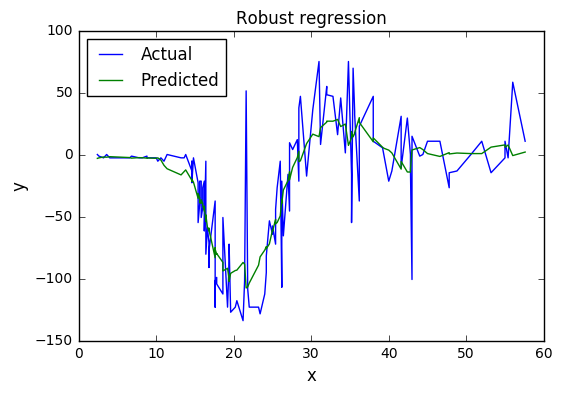

In [9]:
predictedRData = pd.DataFrame(columns=['x', 'y'])
for i in range(len(data)):
    testPoint = list(data.loc[i])[1:]
    trainSet = pd.concat([data[:i], data[(i + 1):]])
    predictedValue = robustRegressionCalculation(testPoint, trainSet, bestRParameters)
    resultPoint = pd.DataFrame([[testPoint[0], predictedValue]], columns=['x', 'y'])
    predictedRData = predictedRData.append(resultPoint, ignore_index=True)

showPredictedData(data, predictedRData, 'Robust regression')

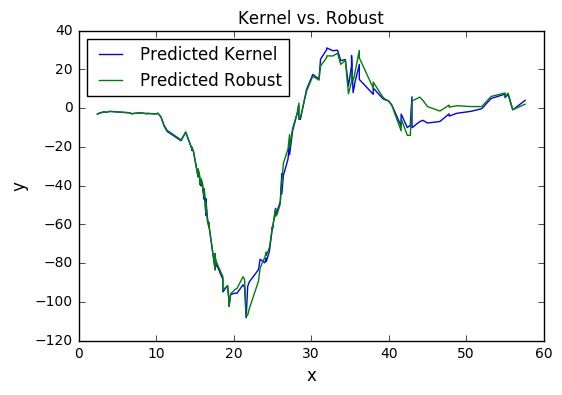

In [10]:
showPredictedData(predictedKData, predictedRData, 'Kernel vs. Robust', r'Predicted Kernel', r'Predicted Robust')